# Pracenje objekata i prebrojavanje - video

### Dobavljanje dataseta

In [1]:
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.datasets import fetch_mldata
import numpy as np

mnist = fetch_mldata('MNIST original')
data   = mnist.data / 255.0
labels = mnist.target.astype('int')

### Uzimanje slucajnog uzorka za obuku i testiranje

In [2]:
train_rank = 5000
test_rank = 100
#------- MNIST subset --------------------------
train_subset = np.random.choice(data.shape[0], train_rank)
test_subset = np.random.choice(data.shape[0], test_rank)

# train dataset
train_data = data[train_subset]
train_labels = labels[train_subset]

# test dataset
test_data = data[test_subset]
test_labels = labels[test_subset]

### Transformacija labela u oblik koji ce biti na izlazu NM

In [3]:
#def to_categorical(labels, n):
#    retVal = np.zeros((len(labels), n), dtype='int')
#    ll = np.array(list(enumerate(labels)))
#    retVal[ll[:,0],ll[:,1]] = 1
#    return retVal

#test = [3, 5, 9]
#print to_categorical(test, 10)

In [4]:
# train and test to categorical
#train_out = to_categorical(train_labels, 10)
#test_out = to_categorical(test_labels, 10)

### Import Keras biblioteka za NM

In [5]:
#--------------- ANN ------------------
#from keras.models import Sequential
#from keras.layers.core import Activation, Dense
#from keras.optimizers import SGD

### Konfiguracija NM

In [6]:
# prepare model
#model = Sequential()
#model.add(Dense(70, input_dim=784))
#model.add(Activation('relu'))
#model.add(Dense(50))
#model.add(Activation('tanh'))
#model.add(Dense(10))
#model.add(Activation('relu'))

In [7]:
# compile model with optimizer
#sgd = SGD(lr=0.1, decay=0.001, momentum=0.7)
#model.compile(loss='mean_squared_error', optimizer=sgd)

### Obucavanje i evaluacija NM

In [8]:
# training
#training = model.fit(train_data, train_out, nb_epoch=500, batch_size=400, verbose=0)
#print training.history['loss'][-1]

In [9]:
# evaluate on test data
#scores = model.evaluate(test_data, test_out, verbose=1)
#print 'test', scores

In [13]:
# evaluate on train data
#scores = model.evaluate(train_data, train_out, verbose=1)
#print 'train', scores

### Import OpenCV i ostalih biblioteka

In [14]:
import os.path
import sys
sys.path.append('code/')

import cv2
from scipy import ndimage
from vector import distance, pnt2line
from matplotlib.pyplot import cm 
import itertools
import time
import math

## KNN - train

In [15]:
ccc=0

train_data_2 = np.zeros((data.shape[0], 400 ))
train_labels_2 = labels.copy()

if os.path.isfile('output/train_data/knn_data.npz'):
    #load data
    with np.load('output/train_data/knn_data.npz') as filedata:
        #print data.files
        train_data_2 = filedata['train']
        train_labels_2 = filedata['train_labels']
        
else:    
    for i in range(len(train_data_2)):
        ccc+=1
        img = data[i].reshape(28,28)*255
        train_data_2[i] = transformDigitPosition(img, 20).reshape(400)
        plt.imsave('output/train_sample/' + str(ccc) + '.png', train_data_2[i].reshape(20,20))
        
    train_data_2 = train_data_2.astype(np.float32)
    # save the data
    np.savez('output/train_data/knn_data.npz',train=train_data_2, train_labels=train_labels_2)

# Initiate kNN, train the data, then test it with test data for k=1
knn = cv2.ml.KNearest_create()
knn.train(train_data_2, cv2.ml.ROW_SAMPLE, train_labels_2)
#ret,result,neighbours,dist = knn.findNearest(test,k=1)

# Now we check the accuracy of classification
# For that, compare the result with test_labels and check which are wrong
#matches = result==test_labels
#correct = np.count_nonzero(matches)
#accuracy = correct*100.0/result.size
#print 'accuracy: ' + str(accuracy)

True

### Pomocne funkcije

In [16]:
cc = -1
def nextId():
    global cc
    cc += 1
    return cc

In [17]:
passIDs = {}

def addId(id, patch):
    global passIDs
    if id not in passIDs:
        print 'element with id:' + str(id) + ' passsed line ' + id.split('_')[1]
        plt.imsave('output/' + str(id) + '.png', patch)
        passIDs[id] = patch
        #operations.append(operation)

In [18]:
#pauziranje videa
p = False
def pause():
    global p
    p = True
    while (p):        
        k = cv2.waitKey(1) & 0xff
        if k == 27:
            pause = False
            break
        

### Ucitavanje video zapisa

In [19]:
linesExpected = 2
lvl = 'lvl3'
video = 'video-1'

cap = cv2.VideoCapture("videos/" + lvl + "/" + video + ".avi") #output.avi

#CV_CAP_PROP_FRAME_COUNT = 7
caplength = int(cap.get(7))
#capwidth  = int(cap.get(cv2.CV_CAP_PROP_FRAME_WIDTH))
#capheight = int(cap.get(cv2.CV_CAP_PROP_FRAME_HEIGHT))
#capfps    = cap.get(cv2.CV_CAP_PROP_FPS)

#line = [(100,450), (500, 100)]

### Povezivanje objekata izmedju frejmova

In [20]:
def inRange(r, item, items):
    retVal = []
    for obj in items:
        mdist = distance(item['center'], obj['center'])
        if(mdist<r):
            retVal.append(obj)
    return retVal

### Kolor filter

In [21]:
# color filter
kernel = np.ones((2,2),np.uint8)
lower = np.array([230, 230, 230])
upper = np.array([255, 255, 255])

#boundaries = [([230, 230, 230], [255, 255, 255])]


### Incijalizacija output video zapisa

In [22]:
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('images/output-rezB.avi',fourcc, 20.0, (640,480))

elements = []
t =0
counter = 0
times = []
#za dimenzije video zapisa
(h,w,c) = (0,0,0)
#velicina isecka na frejmu
blok_size = (28,28)


### Racunanje jednacine prave na osnovu pocetne i krajnje tacke

In [23]:
def calcLineCoeff(x1, y1, x2, y2):
    a = np.array([[x1,1],[x2,1]])
    b = np.array([y1,y2])
    [k, n] = np.linalg.solve(a,b)
    #print 'k=' + str(k) + ' n=' + str(n)
    return [k, n]

### Konacne pozicije linija na osnovu skupa linija dobijenih Hough transformacijom

In [24]:
linesEndpoints = []

def calcLinesEndpoints(label, lines):
    groupedLines = [[], []]
    for i in range(len(label)):
        line = lines[i][0]
        #line = lines[i]
        groupedLines[int(label[i])].append(line)
        
    for j in range(len(groupedLines)):
        minval = (-1,-1)
        maxval = (10000,10000)
        lines = groupedLines[j]
        for p in lines:
            if (p[1]>minval[1]):
                minval = (p[0], p[1])
            if (p[3]<maxval[1]):
                maxval = (p[2], p[3])
            
            #if (p[0]>minval[0]):
            #    minval = (p[0], p[1])
            #if (p[0]<maxval[0]):
            #    maxval = (p[0], p[1])
            
        #print maxval,minval
        global linesEndpoints
        linesEndpoints.append([minval, maxval])
    
    #izbrisi nepostojecu liniju
    if linesExpected != len(linesEndpoints):
        linesEndpoints.pop()
        
    print 'linesEndpoints: ' + str(linesEndpoints)

### Canny detekcija linija i Hough Transformacija

In [25]:
def detectLines(image, linesExp):
    #cv2.rectangle(image, (390,5), (610, 50), (0, 0, 0), -1)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #gray = cv2.dilate(gray, kernel)
    gray = cv2.erode(gray, kernel)
    edges = cv2.Canny(gray, 70, 130, apertureSize = 5)  #50,150,3    
    
    minLineLength = 30
    maxLineGap = 10
    
    lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
    #print 'lines detected: ' + str(len(lines))
    
    #print str(lines)
    
    frm = np.zeros((image.shape[0],image.shape[1],3), np.uint8)  
    
    coeffs = []
    lineCount = 0
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(frm,(x1,y1),(x2,y2),(0,255,0),2)
        kn = calcLineCoeff(x1, y1, x2, y2)            
        coeffs.append(kn)
        cv2.line(frm,(x1,y1),(x2,y2),(0,255,0),2)         
        lineCount+=1
    coeffs = np.float32(coeffs) 
    
    # define criteria and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret,label,center=cv2.kmeans(coeffs,linesExp,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    #print str(label)
    
    #plotdata
    plt.scatter(coeffs[:,0],coeffs[:,1],c = 'r')
    plt.scatter(center[:,0],center[:,1],s = 80,c = 'y', marker = 's')
    plt.xlabel('k - koeficijent pravca'),plt.ylabel('n - odsecak na y-osi')
    plt.show()

    calcLinesEndpoints(label, lines)

    #iscrtaj krajeve linija
    for line in linesEndpoints:
        cv2.circle(frm, line[0], 5, (255, 255, 0), 2)
        cv2.circle(frm, line[1], 5, (255, 255, 0), 2)
    plt.imshow(edges)    
    #plt.imshow(frm, cmap='gray', interpolation='nearest')

### Pozicioniranje cifre na patchu u gornji-levi ugao patcha 

In [26]:
def transformDigitPosition1(patch, dim):
    x,y,w,h = cv2.boundingRect(patch)
    patch = patch[y:y+h, x:x+w]        
    hgap = np.zeros((dim-h, w))
    patch = np.vstack((patch, hgap))
    vgap = np.zeros((dim, dim-w))
    patch = np.hstack((patch, vgap))    
    return patch

In [27]:
def transformDigitPosition(patch, dim):
    x = 0
    y = 0
    w = 0
    h = 0    
    #east
    for i in range(patch.shape[0]):
        col = patch[:,i]
        if np.argmax(col) > 0:
            x = i
            break
    #west        
    for i in reversed(range(patch.shape[0])):
        col = patch[:,i]
        if np.argmax(col) > 0:
            w = i - x
            break    
    #north
    for i in range(patch.shape[1]):
        row = patch[i,:]
        if np.argmax(row) > 0:
            y = i
            break    
    #south
    for i in reversed(range(patch.shape[1])):
        row = patch[i,:]
        if np.argmax(row) > 0:
            h = i - y
            break
    h+=1
    w+=1
    patch = patch[y:y+h, x:x+w]
    hgap = np.zeros((dim-h, w))
    patch = np.vstack((patch, hgap))
    vgap = np.zeros((dim, dim-w))
    patch = np.hstack((patch, vgap))
    #ret,img = cv2.threshold(img,10,255,0)
    return patch        
    

## Glavna petlja

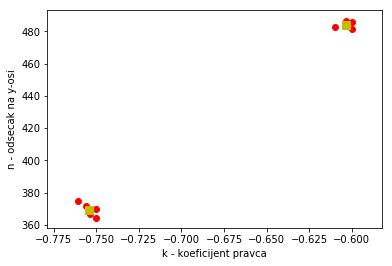

linesEndpoints: [[(183, 376), (431, 223)], [(223, 203), (420, 50)]]
id:5 value:3
id:9 value:8
id:4 value:0
id:7 value:1
id:6 value:8
id:5 value:3
id:23 value:2
id:15 value:3
id:4 value:0
id:1 value:6
id:22 value:1
id:0 value:0
id:25 value:9
id:24 value:9
id:15 value:3
id:28 value:0
id:1 value:6
id:26 value:4
id:22 value:1
id:32 value:2
id:30 value:3
id:29 value:5
id:33 value:1
id:17 value:3
id:29 value:5
id:27 value:0
id:0 value:0
id:50 value:9
id:47 value:1
id:35 value:7
id:46 value:9
id:56 value:7
id:46 value:9
id:17 value:3
id:57 value:1
Suma = 6.0
mean 21.61 ms


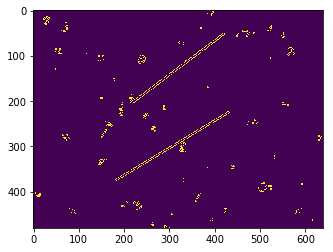

In [28]:
patchCounter = 0
frameCounter = 0
plotCounter = 0
total = 0

while(1):
    
    frameCounter += 1 
    start_time = time.time()
    ret, img = cap.read()
    #print ret, img

    if ret == False:
        break
        
    if (frameCounter == 1):
        detectLines(img, linesExpected)
    
    #########################
    #if (frameCounter == 200):
    #    break

    # create NumPy arrays from the boundaries
    lower = np.array(lower, dtype = "uint8")
    upper = np.array(upper, dtype = "uint8")
    #print('lower: ' + str(lower) + ' -- ' + 'upper: ' + str(upper))
    mask = cv2.inRange(img, lower, upper)
    img0 = 1.0*mask        

    img0 = cv2.dilate(img0,kernel) #cv2.erode(img0,kernel)
    img0 = cv2.dilate(img0,kernel)  
    
    labeled, nr_objects = ndimage.label(img0)    
    objects = ndimage.find_objects(labeled)
    
    for i in range(nr_objects):
        #za svaki pronadjen objekat racunamo centar (xc, yc) i velicinu (dxc, dyc)
        loc = objects[i]
        (xc,yc) = ((loc[1].stop + loc[1].start)/2,
                   (loc[0].stop + loc[0].start)/2)
        (dxc,dyc) = ((loc[1].stop - loc[1].start),
                   (loc[0].stop - loc[0].start))      
        
        #ako je velicina pronadjenog objekta veca od 11 po nekoj od osa, verovatno se radi o broju
        if(dxc>11 or dyc>11):
            #cv2.circle(img, (xc,yc), 16, (25, 25, 255), 1)
            elem = {'center':(xc,yc), 'size':(dxc,dyc), 't':t}  
            
            # find in range
            lst = inRange(30, elem, elements)
            nn = len(lst)
            if nn == 0:
                elem['id'] = nextId()
                elem['t'] = t
                elem['pass'] = [False] if linesExpected == 1 else [False, False]
                elem['history'] = [{'center':(xc,yc), 'size':(dxc,dyc), 't':t}]
                elem['future'] = []
                elem['value'] = None
                ###################################################
                blok_loc = (xc-10, yc-10)
                imgB = img0[yc-10:yc+10,
                        xc-10:xc+10]
                imgB = cv2.erode(imgB, kernel)
                #imgB = cv2.erode(imgB, kernel)
                (h,w) = imgB.shape
                if (h*w == 400):
                    patchCounter+=1
                    #plt.imsave('output/' + str(frameCounter) + '-' + str(el['id']) + '.png', img)
                    elem['patch'] = imgB
                ###################################################
                elements.append(elem)
            elif nn == 1:
                lst[0]['center'] = elem['center']
                lst[0]['t'] = t
                lst[0]['history'].append({'center':(xc,yc), 'size':(dxc,dyc), 't':t}) 
                lst[0]['future'] = []               
                        
    for el in elements:
        tt = t - el['t']
        if(tt<3):
            cl = [(25, 255, 255), (255, 255, 25)]
            for le in range(len(linesEndpoints)):
                dist, pnt, r = pnt2line(el['center'], linesEndpoints[le][0], linesEndpoints[le][1])
                if r>0:
                    #cv2.line(img, pnt, el['center'], cl[le], 1)
                    c = (25, 25, 255)
                    if(dist<9):
                        c = (0, 255, 160)
                        if el['pass'][le] == False:
                            el['pass'][le] = True
                            #addId(str(el['id']) + '_' + str(le), el['patch'])
                            patch = np.array(el['patch'])
                            patch = np.uint8(patch)
                            patch = transformDigitPosition(patch, 20)
                            original = patch.copy()
                            patch = np.float32(patch.reshape(-1,400))                            
                            ret,result,neighbours,dist = knn.findNearest(patch, k=1)
                            print 'id:' + str(el['id']) + ' value:'+ str(int(ret))
                            plt.imsave('output/prediction/'+ lvl + '/' + video + '/' 
                                       + str(counter) + '_id-' + str(el['id']) + '_val-' + str(int(ret)) + '.png', original)
                            if le == 0:
                                total += ret
                            else:
                                total -= ret
                            counter += 1

            cv2.circle(img, el['center'], 16, c, 2)

            id = el['id']
            cv2.putText(img, str(el['id']), 
                (el['center'][0]+10, el['center'][1]+10), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, 255)
            
            #iscrtavanje zutih krugova na prethodnim lokacijama objekata
            for hist in el['history']:
                ttt = t-hist['t']
                #if(ttt<100):
                    #cv2.circle(img, hist['center'], 1, (0, 255, 255), 1)

            for fu in el['future']:
                ttt = fu[0]-t
                if(ttt<100):
                    cv2.circle(img, (fu[1], fu[2]), 1, (255, 255, 0), 1)
                    
    #iscrtaj krajeve linija
    for line in linesEndpoints:
        cv2.circle(img, line[0], 5, (255, 255, 0), 2)
        cv2.circle(img, line[1], 5, (255, 255, 0), 2)
                    
    elapsed_time = time.time() - start_time
    times.append(elapsed_time*1000)
    cv2.putText(img, 'Suma: '+str(total), (450, 20), cv2.FONT_HERSHEY_SIMPLEX, 1,(90,90,255),2)
    
    #if (frameCounter == 600):
    #    plt.imsave('output/aaa.png', img0)

    #print nr_objects
    t += 1
    #if t%10==0:
        #print t
    cv2.imshow('frame', img)
    k = cv2.waitKey(1) & 0xff
    if k == 27:
        pause()
    out.write(img)    
    #print 'frame: ' + str(frameCounter) + ' [END]'
out.release()        
cap.release()
cv2.destroyAllWindows()

print 'Suma = ' + str(total) 

et = np.array(times)
print 'mean %.2f ms'%(np.mean(et))
#print np.std(et)

## ANN

In [29]:
#keys = passIDs.keys()
#result = 0
#for k in keys:
#    imgB = passIDs[k]
#    (h,w) = imgB.shape
#    if (h*w == 784):
#        imgB_test = imgB.reshape(784)
#        imgB_test = imgB_test/255.
#        print 'za element sa id: ' + str(k)
#        tt = model.predict(np.array([imgB_test]), verbose=1)
#        rez_t = tt.argmax(axis=1)
#        result += rez_t[0]
#        print 'procenjena vrednost: ' + str(rez_t[0])
#        print '---------------------------------------'
        
#print 'Ukupan zbir = ' + str(result)